In [1]:
import os

os.chdir('/Users/alexascunceparis/Desktop/BSC/immuno_project/TCRranker')

from find_contact_map import *
from mapping import *
from select_nr_set import *
from extract_contacts import *

seq_dict=parse_general_file('./structures_annotation/general.txt')

# Chain dictionary
general_df=pd.read_csv('./structures_annotation/general.txt', sep='\t')
chain_dict = {}
for pdb_id, group in general_df.groupby('pdb.id'):
    chains = {
            'tcra_chain': None,
            'tcrb_chain': None,
            'peptide_chain': None,
            'mhc_chain': None
        }
        
    for _, row in group.iterrows():
        if row['chain.component'] == 'TCR' and row['chain.type'] == 'TRA':
            chains['tcra_chain'] = row['chain.id']
        elif row['chain.component'] == 'TCR' and row['chain.type'] == 'TRB':
            chains['tcrb_chain'] = row['chain.id']
        elif row['chain.component'] == 'PEPTIDE':
            chains['peptide_chain'] = row['chain.id']
        elif row['chain.component'] == 'MHC' and row['chain.supertype'] == 'MHCI' and row['chain.type'] == 'MHCa':
            chains['mhc_chain'] = row['chain.id']
        
    chain_dict[pdb_id] = chains

/opt/miniconda3/envs/anarci/lib/python3.12/site-packages/tcrdist/olga_load_model.py:3: SyntaxWarning: invalid escape sequence '\p'
  """Define classes for V(D)J generative models and genomic data.
/opt/miniconda3/envs/anarci/lib/python3.12/site-packages/olga/utils.py:493: SyntaxWarning: invalid escape sequence '\s'
  """Calculate the entropy of an insertion junction.
/opt/miniconda3/envs/anarci/lib/python3.12/site-packages/olga/generation_probability.py:523: SyntaxWarning: invalid escape sequence '\['
  bracket_ex = [x for x in re.findall('\[[' + aa_symbols + ']*?\]|\{\d+,{0,1}\d*\}', regex_seq)]
/opt/miniconda3/envs/anarci/lib/python3.12/site-packages/olga/generation_probability.py:523: SyntaxWarning: invalid escape sequence '\]'
  bracket_ex = [x for x in re.findall('\[[' + aa_symbols + ']*?\]|\{\d+,{0,1}\d*\}', regex_seq)]
/opt/miniconda3/envs/anarci/lib/python3.12/site-packages/olga/generation_probability.py:526: SyntaxWarning: invalid escape sequence '\['
  split_seq  = re.split('

In [3]:
import os
import pandas as pd

# Variables para almacenar todos los contactos
all_contacts_pep = []
all_contacts_mhc = []

# Recorre todos los archivos en el directorio "./contact_maps"
for contac_map in os.listdir("./contact_maps"):
    if contac_map.endswith(".csv"):
        df = pd.read_csv(f'./contact_maps/{contac_map}')
        pdb_id = contac_map.split('_')[0]
        pdb_file_path = f'./pdb_files/{pdb_id}.pdb'
        print("Processing pdb id:", pdb_id)
        
        # Aquí debes ajustar el acceso a 'chain_dict' y 'pdb_id_similar'
        chains = chain_dict.get(pdb_id, {})  # Cambié 'pdb_id_similar' por 'pdb_id'
        
        # Asegurarse de que todas las cadenas estén presentes
        if all(chains.values()):
            # Filtrar contactos
            contacts_TCR_p, contacts_TCR_MHC = filter_contacts(
                df,
                chains['tcra_chain'],
                chains['tcrb_chain'],
                chains['peptide_chain'],
                chains['mhc_chain'],
                threshold=1
            )
            
            # Mapeo con la numeración IMGT
            print("Renumbering sequences with IMGT convention")
            
            # Extrae las secuencias específicas
            alpha_pdb, beta_pdb, epitope_pdb = extract_specific_sequences(pdb_file_path, seq_dict)
            if len(epitope_pdb) == 9:
                # Corre ANARCI
                anarci_D = run_anarci(alpha_pdb, 'alpha')
                anarci_E = run_anarci(beta_pdb, 'beta')
                parsed_anarci_D = parse_anarci_output(anarci_D)
                parsed_anarci_E = parse_anarci_output(anarci_E)

                # Extraer residuos y resid ID de las cadenas TCR
                residues_D = extract_residues_and_resids(pdb_file_path, chains['tcra_chain'])
                residues_E = extract_residues_and_resids(pdb_file_path, chains['tcrb_chain'])

                # Mapeo IMGT con ANARCI
                mapping_D = map_imgt_to_original(parsed_anarci_D, residues_D)
                mapping_E = map_imgt_to_original(parsed_anarci_E, residues_E)

                # Genera un diccionario de mapeo IMGT para este pdb
                imgt_mappings = {pdb_id: {chains['tcra_chain']: mapping_D, chains['tcrb_chain']: mapping_E}}

                # Agregar mapeo IMGT a los contactos TCR-MHC y péptido
                contacts_imgt_M = add_imgt_mappings(contacts_TCR_MHC, imgt_mappings)
                contacts_imgt_P = add_imgt_mappings(contacts_TCR_p, imgt_mappings)
                print("IMGT mapping done")

                # Añadir a las listas
                all_contacts_mhc.append(contacts_imgt_M)
                all_contacts_pep.append(contacts_imgt_P)

# Concatenar todos los DataFrames
df_all_contacts_mhc = pd.concat(all_contacts_mhc, ignore_index=True)
df_all_contacts_pep = pd.concat(all_contacts_pep, ignore_index=True)


Processing pdb id: 7n2p
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 4jfd
Renumbering sequences with IMGT convention
Processing pdb id: 7l1d
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 2gj6
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 4jry
Renumbering sequences with IMGT convention
Processing pdb id: 5wkf
Renumbering sequences with IMGT convention
Processing pdb id: 2ckb
Renumbering sequences with IMGT convention
Processing pdb id: 7jwj
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 8gvb
Renumbering sequences with IMGT convention
Processing pdb id: 5ivx
Renumbering sequences with IMGT convention
Processing pdb id: 2ypl
Renumbering sequences with IMGT convention
Processing pdb id: 5isz
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 7n4k
Renumbering sequences with IMGT convention
Processing pdb id: 6bj3
Renumbering seq

In [11]:
import os
import pandas as pd

# Diccionario para almacenar listas de contactos por longitud de epítopo
contacts_pep_by_length = {}
contacts_mhc_by_length = {}

# Recorre todos los archivos en el directorio "./contact_maps"
for contac_map in os.listdir("./contact_maps"):
    if contac_map.endswith(".csv"):
        df = pd.read_csv(f'./contact_maps/{contac_map}')
        pdb_id = contac_map.split('_')[0]
        pdb_file_path = f'./pdb_files/{pdb_id}.pdb'
        print("Processing pdb id:", pdb_id)
        
        # Acceso a 'chain_dict' y comprobación de las cadenas
        chains = chain_dict.get(pdb_id, {})
        
        # Asegurarse de que todas las cadenas estén presentes
        if all(chains.values()):
            # Filtrar contactos
            contacts_TCR_p, contacts_TCR_MHC = filter_contacts(
                df,
                chains['tcra_chain'],
                chains['tcrb_chain'],
                chains['peptide_chain'],
                chains['mhc_chain'],
                threshold=1
            )
            
            # Mapeo con la numeración IMGT
            print("Renumbering sequences with IMGT convention")
            
            # Extrae las secuencias específicas
            alpha_pdb, beta_pdb, epitope_pdb = extract_specific_sequences(pdb_file_path, seq_dict)
            epitope_length = len(epitope_pdb)  # Obtener la longitud del epítopo
            
            # Procesar solo si el epítopo tiene una longitud válida
            if epitope_length > 0:
                # Corre ANARCI
                anarci_D = run_anarci(alpha_pdb, 'alpha')
                anarci_E = run_anarci(beta_pdb, 'beta')
                parsed_anarci_D = parse_anarci_output(anarci_D)
                parsed_anarci_E = parse_anarci_output(anarci_E)

                # Extraer residuos y resid ID de las cadenas TCR
                residues_D = extract_residues_and_resids(pdb_file_path, chains['tcra_chain'])
                residues_E = extract_residues_and_resids(pdb_file_path, chains['tcrb_chain'])

                # Mapeo IMGT con ANARCI
                mapping_D = map_imgt_to_original(parsed_anarci_D, residues_D)
                mapping_E = map_imgt_to_original(parsed_anarci_E, residues_E)

                # Genera un diccionario de mapeo IMGT para este pdb
                imgt_mappings = {pdb_id: {chains['tcra_chain']: mapping_D, chains['tcrb_chain']: mapping_E}}

                # Agregar mapeo IMGT a los contactos TCR-MHC y péptido
                contacts_imgt_M = add_imgt_mappings(contacts_TCR_MHC, imgt_mappings)
                contacts_imgt_P = add_imgt_mappings(contacts_TCR_p, imgt_mappings)
                print("IMGT mapping done")

                # Añadir a la lista de contactos para la longitud específica de epítopo
                contacts_pep_by_length.setdefault(epitope_length, []).append(contacts_imgt_P)
                contacts_mhc_by_length.setdefault(epitope_length, []).append(contacts_imgt_M)

# Crear un DataFrame conjunto para cada longitud de epítopo
df_all_contacts_pep_by_length = {length: pd.concat(df_list, ignore_index=True) 
                                 for length, df_list in contacts_pep_by_length.items()}
df_all_contacts_mhc_by_length = {length: pd.concat(df_list, ignore_index=True) 
                                 for length, df_list in contacts_mhc_by_length.items()}

Processing pdb id: 7n2p
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 4jfd
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 7l1d
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 2gj6
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 4jry
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 5wkf
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 2ckb
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 7jwj
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 8gvb
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 5ivx
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 2ypl
Renumbering sequences with IMGT convention
IMGT mapping done
Processing pdb id: 5isz
Renumbering sequences with IMGT conventio

In [4]:
df_all_contacts_pep.head()

,pdb_id,chain_from,chain_to,residue_from,residue_to,resid_from,resid_to,imgt_from
0,7n2p,D,C,A,M,30,4,29
1,7n2p,D,C,F,M,96,4,109
2,7n2p,D,C,I,M,31,4,36
3,7n2p,D,C,S,M,53,4,58
4,7n2p,D,C,S,V,54,3,59


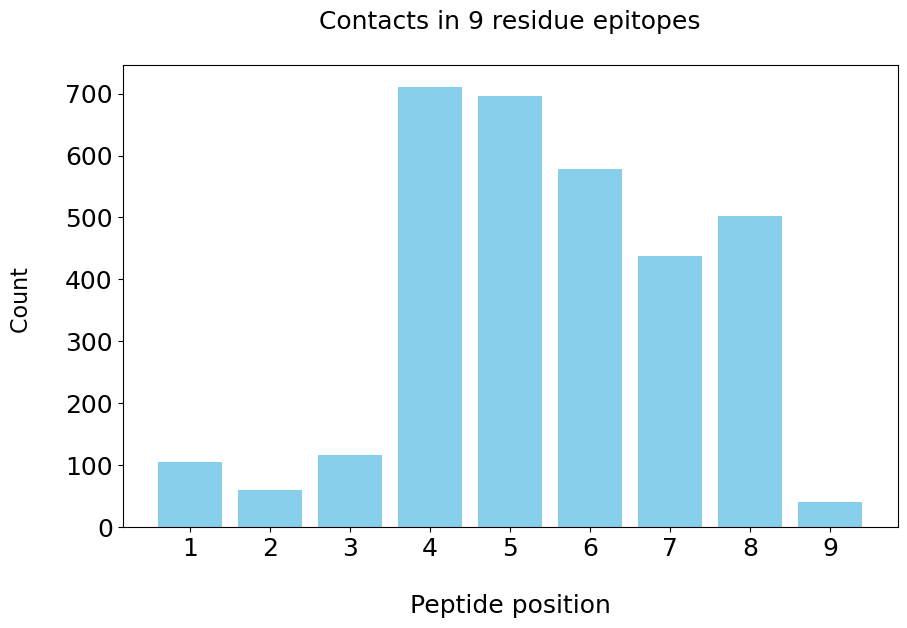

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el DataFrame basado en los datos proporcionados
df=df_all_contacts_pep

# Contar la frecuencia de cada valor en 'resid_to' del 1 al 9, incluyendo aquellos que no están presentes
resid_counts = df['resid_to'].value_counts().reindex(range(1, 10), fill_value=0)

# Graficar el barplot
plt.figure(figsize=(10, 6))
plt.bar(resid_counts.index, resid_counts.values, color='skyblue')
plt.xlabel('\nPeptide position', fontsize=18)
plt.ylabel('Count \n', fontsize=16)
plt.title('Contacts in 9 residue epitopes\n', fontsize=18)
plt.xticks(range(1, 10), fontsize=18)
plt.yticks(fontsize=18)
plt.show()


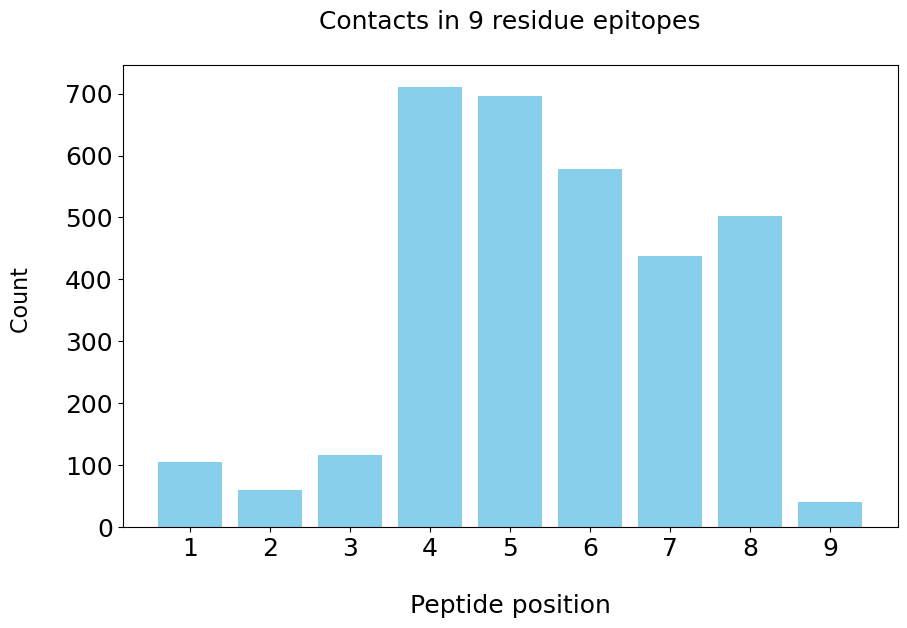

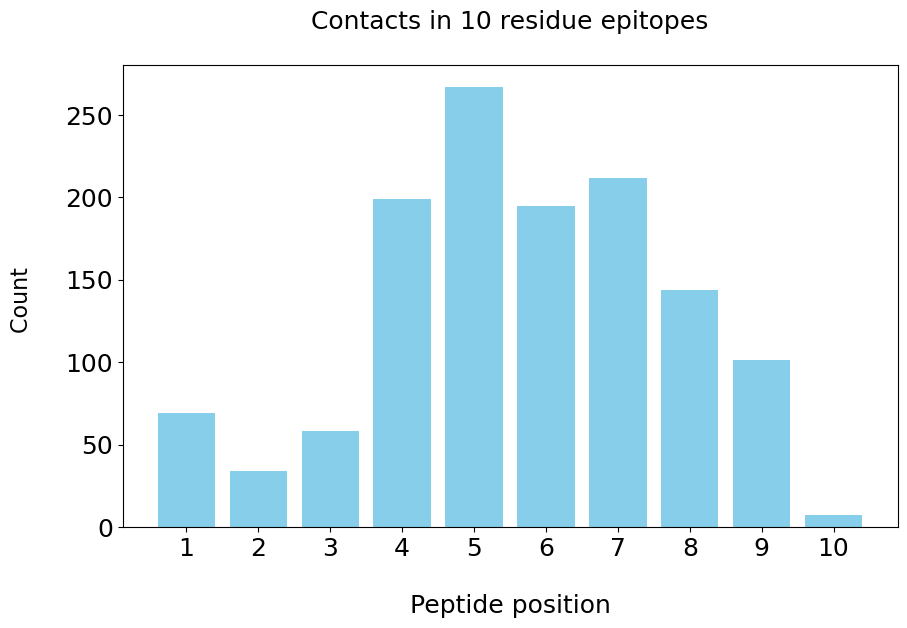

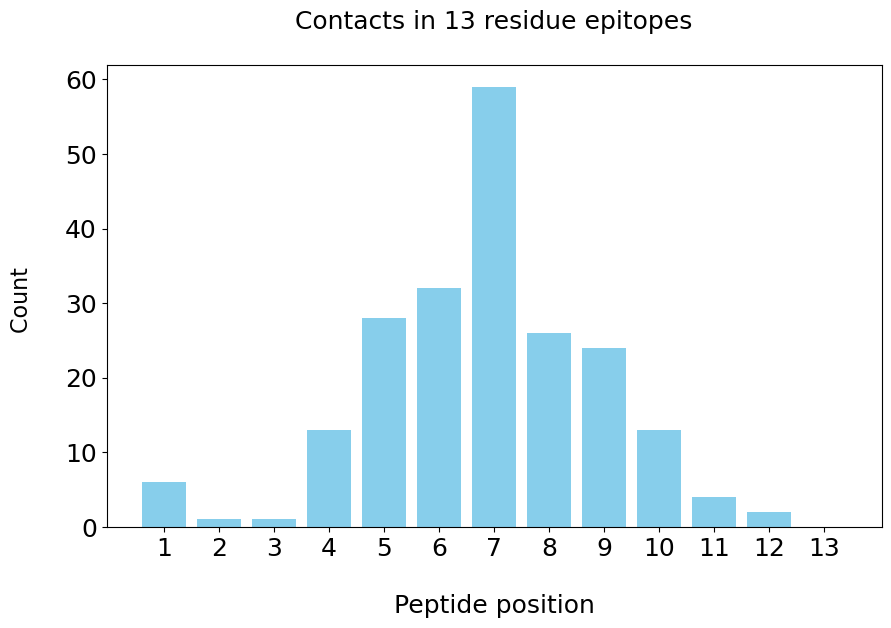

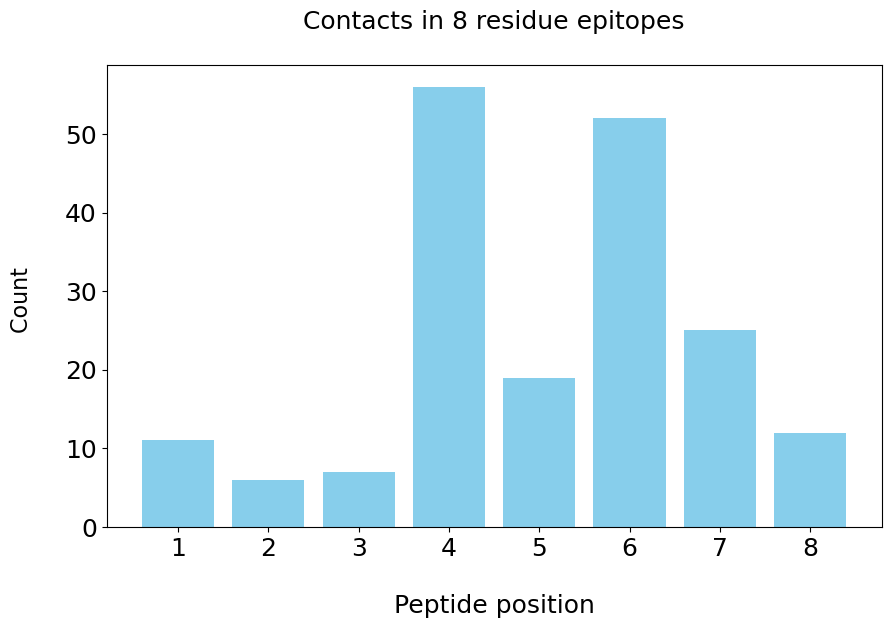

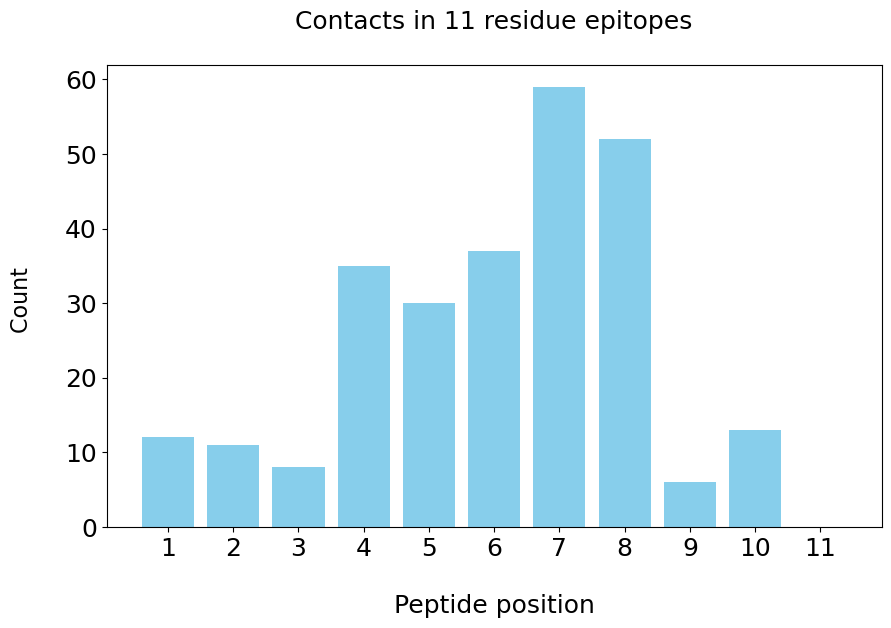

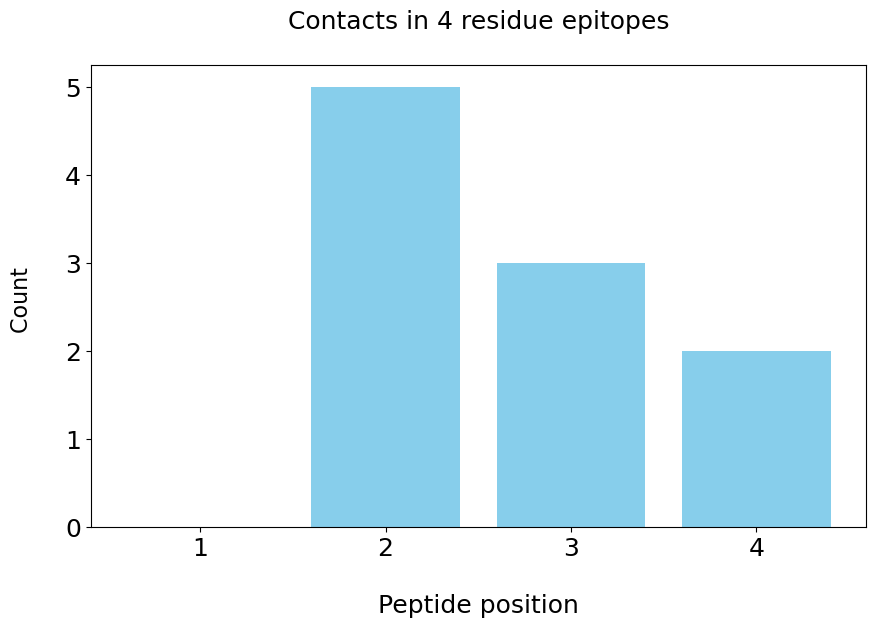

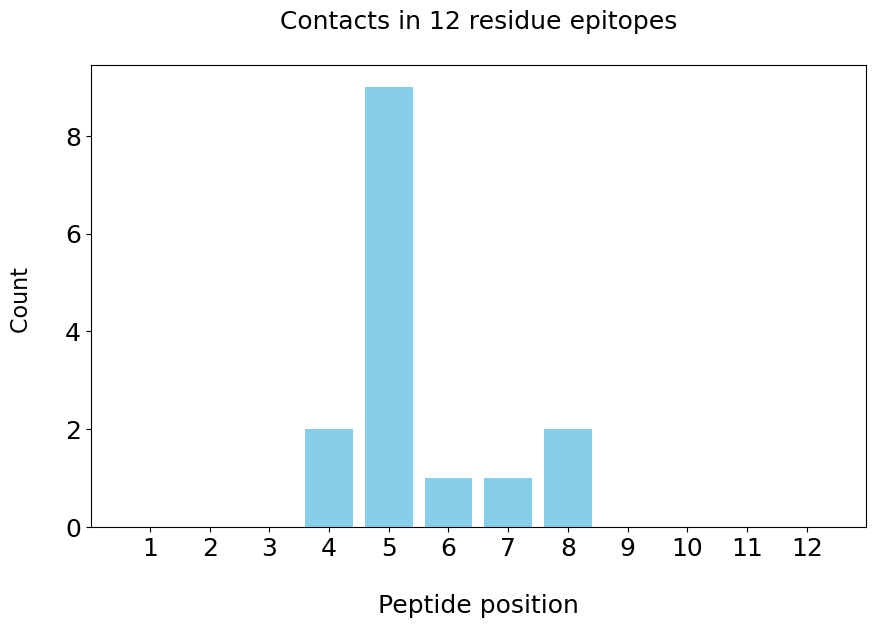

In [12]:
import matplotlib.pyplot as plt

# Iterar sobre cada longitud de epítopo y su respectivo DataFrame
for length, df_pep in df_all_contacts_pep_by_length.items():
    # Contar la frecuencia de cada valor en 'resid_to' del 1 al `length`, incluyendo valores ausentes
    resid_counts = df_pep['resid_to'].value_counts().reindex(range(1, length + 1), fill_value=0)
    
    # Graficar el barplot
    plt.figure(figsize=(10, 6))
    plt.bar(resid_counts.index, resid_counts.values, color='skyblue')
    plt.xlabel('\nPeptide position', fontsize=18)
    plt.ylabel('Count \n', fontsize=16)
    plt.title(f'Contacts in {length} residue epitopes\n', fontsize=18)
    plt.xticks(range(1, length + 1), fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

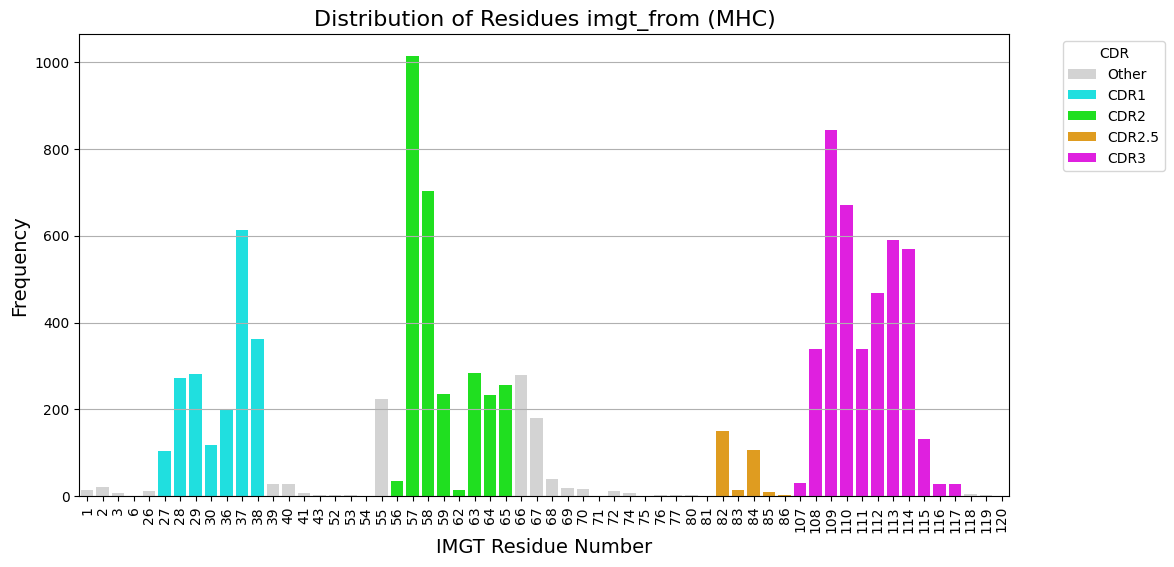

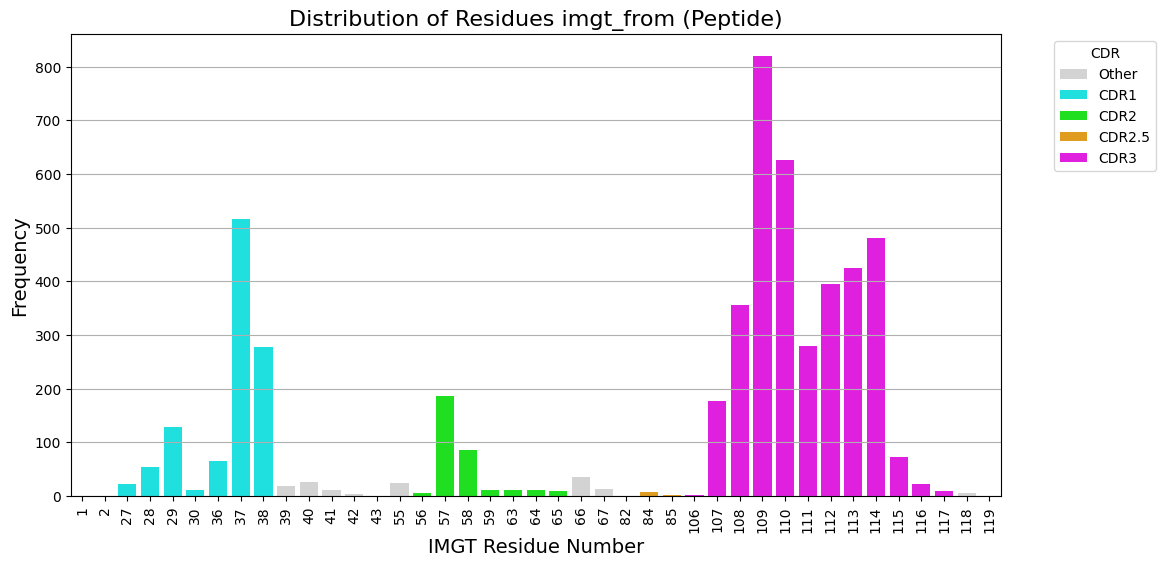

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_all_contacts_mhc and df_all_contacts_pep have the 'imgt_from' column

# Define colors for each CDR region
cdr_colors = {
    'CDR1': 'cyan',       # Color for CDR1
    'CDR2': 'lime',       # Color for CDR2
    'CDR2.5': 'orange',   # Color for CDR2.5
    'CDR3': 'magenta',    # Color for CDR3
    'Other': 'lightgray'  # Color for non-CDR residues
}

# Function to categorize residues into CDRs
def categorize_cdr(num):
    if 27 <= num <= 38:
        return 'CDR1'
    elif 56 <= num <= 65:
        return 'CDR2'
    elif 81 <= num <= 86:
        return 'CDR2.5'
    elif 105 <= num <= 117:
        return 'CDR3'
    else:
        return 'Other'

# Add a new column to categorize residues in MHC DataFrame
if 'imgt_from' in df_all_contacts_mhc.columns:
    df_all_contacts_mhc['CDR'] = df_all_contacts_mhc['imgt_from'].apply(categorize_cdr)

    # Create a bar plot for df_all_contacts_mhc with CDR colors
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_all_contacts_mhc, x='imgt_from', hue='CDR', palette=cdr_colors, order=sorted(df_all_contacts_mhc['imgt_from'].dropna().unique()))
    plt.title('Distribution of Residues imgt_from (MHC)', fontsize=16)
    plt.xlabel('IMGT Residue Number', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=90)  # Rotate x-axis labels if needed
    plt.grid(axis='y')
    plt.legend(title='CDR', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend outside the plot
    plt.show()

# Repeat for peptide DataFrame if needed
if 'imgt_from' in df_all_contacts_pep.columns:
    df_all_contacts_pep['CDR'] = df_all_contacts_pep['imgt_from'].apply(categorize_cdr)

    # Create a bar plot for df_all_contacts_pep with CDR colors
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_all_contacts_pep, x='imgt_from', hue='CDR', palette=cdr_colors, order=sorted(df_all_contacts_pep['imgt_from'].dropna().unique()))
    plt.title('Distribution of Residues imgt_from (Peptide)', fontsize=16)
    plt.xlabel('IMGT Residue Number', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=90)  # Rotate x-axis labels if needed
    plt.grid(axis='y')
    plt.legend(title='CDR', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend outside the plot
    plt.show()

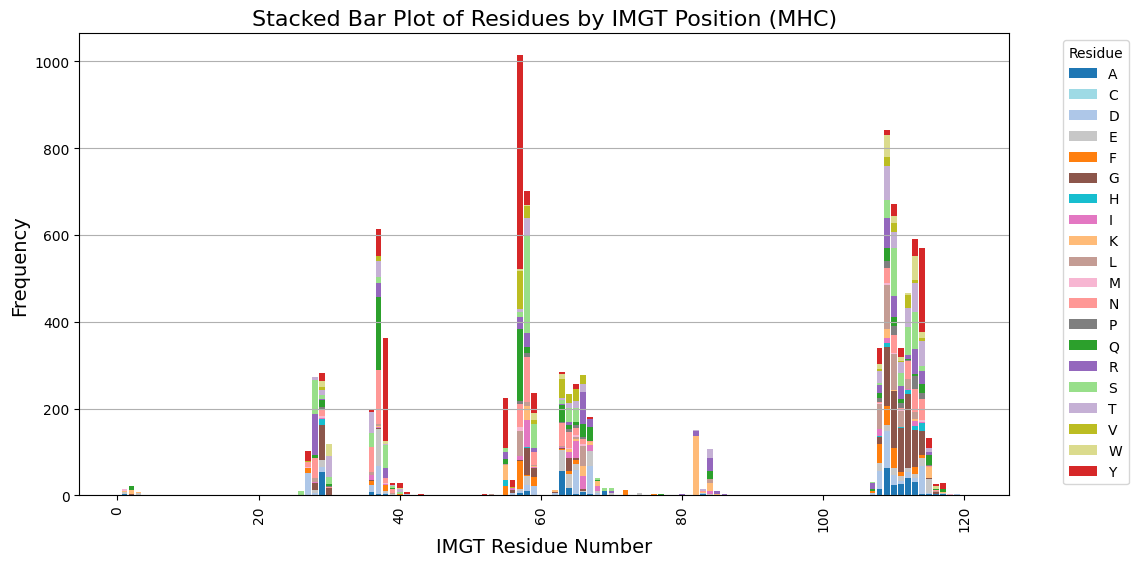

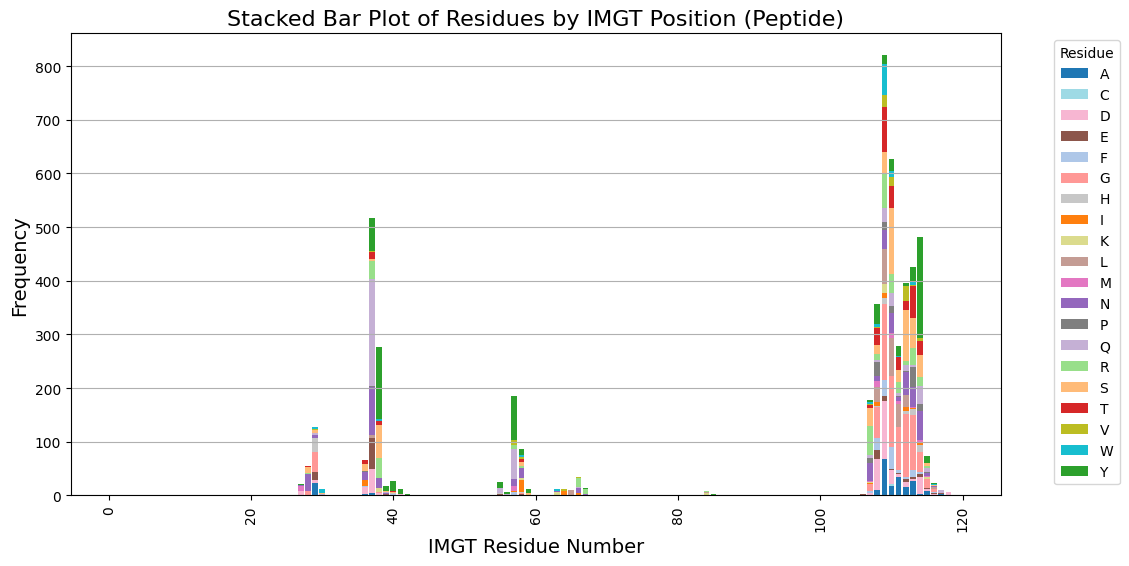

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create a color mapping for residues
def create_color_mapping(df, column):
    unique_residues = df[column].unique()
    num_colors = len(unique_residues)
    
    # Choose a color map based on the number of unique residues
    if num_colors <= 10:
        colors = plt.colormaps['tab10'](np.linspace(0, 1, num_colors))  # Up to 10 distinct colors
    else:
        colors = plt.colormaps['tab20'](np.linspace(0, 1, num_colors))  # Up to 20 distinct colors
    
    return dict(zip(unique_residues, colors)) 

# Create a bar plot for df_all_contacts_mhc with stacked bars based on residue_from
if 'residue_from' in df_all_contacts_mhc.columns:
    # Create color mapping
    color_mapping_mhc = create_color_mapping(df_all_contacts_mhc, 'residue_from')

    # Aggregate counts of residues for proper x-axis labeling
    count_data_mhc = df_all_contacts_mhc.groupby(['imgt_from', 'residue_from']).size().unstack(fill_value=0)

    # Sort by IMGT residue number
    count_data_mhc = count_data_mhc.reindex(sorted(df_all_contacts_mhc['imgt_from'].dropna().unique()))

    # Plot stacked bars
    plt.figure(figsize=(12, 6))
    bottom_values = np.zeros(len(count_data_mhc))  # Start at the bottom for stacked bars

    for residue in count_data_mhc.columns:
        plt.bar(count_data_mhc.index, count_data_mhc[residue], bottom=bottom_values, 
                color=color_mapping_mhc[residue], label=residue)
        bottom_values += count_data_mhc[residue]  # Update bottom for the next residue

    plt.title('Stacked Bar Plot of Residues by IMGT Position (MHC)', fontsize=16)
    plt.xlabel('IMGT Residue Number', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
    plt.grid(axis='y')

    # Show legend with residue names
    plt.legend(title='Residue', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Repeat for peptide DataFrame
if 'residue_from' in df_all_contacts_pep.columns:
    # Create color mapping for peptide residues
    color_mapping_pep = create_color_mapping(df_all_contacts_pep, 'residue_from')

    # Aggregate counts of residues for proper x-axis labeling
    count_data_pep = df_all_contacts_pep.groupby(['imgt_from', 'residue_from']).size().unstack(fill_value=0)

    # Sort by IMGT residue number
    count_data_pep = count_data_pep.reindex(sorted(df_all_contacts_pep['imgt_from'].dropna().unique()))

    # Plot stacked bars
    plt.figure(figsize=(12, 6))
    bottom_values = np.zeros(len(count_data_pep))  # Start at the bottom for stacked bars

    for residue in count_data_pep.columns:
        plt.bar(count_data_pep.index, count_data_pep[residue], bottom=bottom_values, 
                color=color_mapping_pep[residue], label=residue)
        bottom_values += count_data_pep[residue]  # Update bottom for the next residue

    plt.title('Stacked Bar Plot of Residues by IMGT Position (Peptide)', fontsize=16)
    plt.xlabel('IMGT Residue Number', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
    plt.grid(axis='y')

    # Show legend with residue names
    plt.legend(title='Residue', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

Contact Matrix:
imgt_from  1    2    3    6    26   27   28   29   30   36   ...  111  112  \
pdb_id                                                       ...             
1ao7         0    1    0    0    1    1    3    1    0    0  ...    1    5   
1bd2         0    2    0    0    0    0    2    6    0    0  ...    1    1   
1fo0         0    0    0    0    0    0    2    2    1    0  ...    1    2   
1g6r         0    0    0    0    0    1    3    3    0    1  ...    0    0   
1kj2         0    0    0    0    0    2    0    6    0    0  ...    5    3   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8i5d         0    0    0    0    0    0    0    1    0    0  ...    1    0   
8qfy         0    0    0    0    0    0    3    3    0    0  ...    0    0   
8shi         0    0    0    0    0    0    1    0    0    0  ...    5    1   
8wte         0    0    0    0    0    0    1    1    0    0  ...    0    3   
8wul         0    0    0    0    0    0    1    

/var/folders/ks/wvvv20910hn2944q3hp0_v080000gn/T/ipykernel_19315/800726893.py:24: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distances, 'ward')  # You can choose different linkage methods


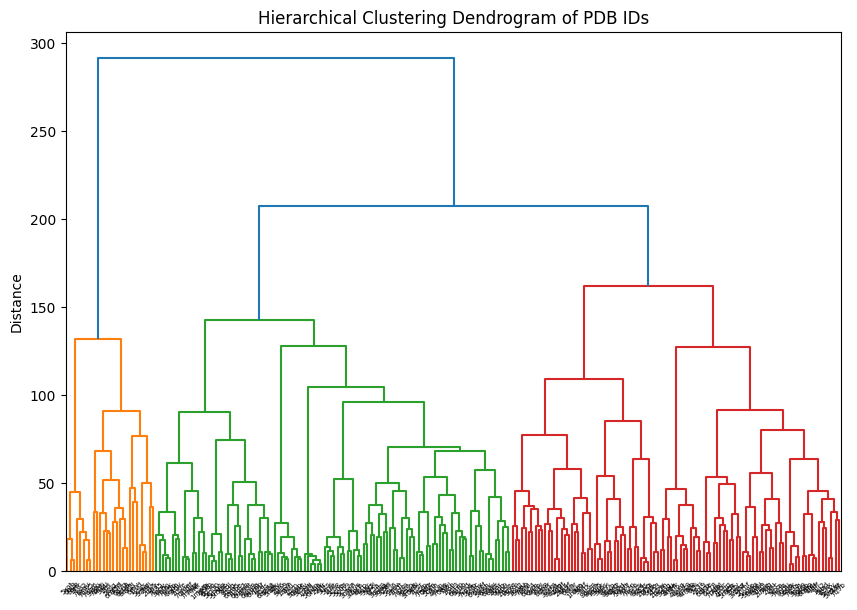

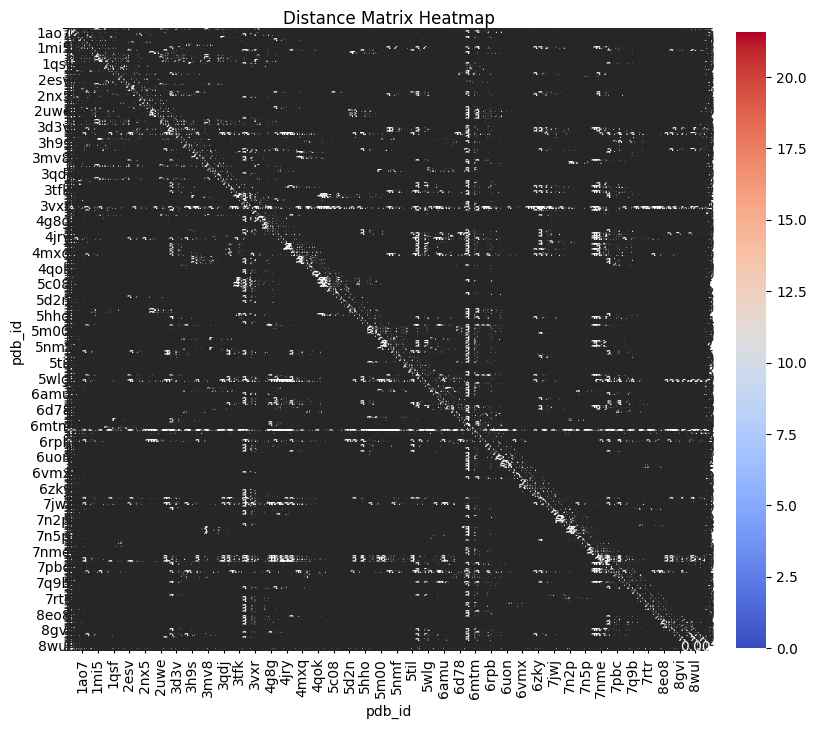

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage

# Step 1: Create a contact matrix
# Generate a matrix with pdb_id as rows and imgt_from residues as columns
contact_matrix = pd.crosstab(df_all_contacts_mhc['pdb_id'], df_all_contacts_mhc['imgt_from'])

# Display the contact matrix
print("Contact Matrix:")
print(contact_matrix)

# Step 2: Calculate pairwise distances
# Calculate the distance matrix
distances = pairwise_distances(contact_matrix, metric='euclidean')

# Convert distances to a DataFrame for easier handling
distances_df = pd.DataFrame(distances, index=contact_matrix.index, columns=contact_matrix.index)

# Step 3: Perform Hierarchical Clustering
linked = linkage(distances, 'ward')  # You can choose different linkage methods

# Step 4: Visualize the Results
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=contact_matrix.index, orientation='top')
plt.title('Hierarchical Clustering Dendrogram of PDB IDs')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()

# Optional: Heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distances_df, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Distance Matrix Heatmap')
plt.show()
